In [1]:
# === PHASE 1.1: LOAD & INSPECT PROJECT DATA ===
# ------------------------------------------------------
# This script reads the main Excel file containing 1000+ project records.
# It validates structure, datatypes, and sample values before transformation.
# ------------------------------------------------------

import pandas as pd

# 📍 Step 1.1.1: Define the file path for your main project data
file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/ML1_Project_Complexity_FULL_EXTENDED.xlsx"

# 📍 Step 1.1.2: Load the Excel file using pandas
# Note: openpyxl is required for .xlsx files
try:
    df_raw = pd.read_excel(file_path, engine='openpyxl')
    print("✅ File loaded successfully.")
except Exception as e:
    print(f"❌ Failed to load file: {e}")

# 📍 Step 1.1.3: Preview the shape and basic info of the dataset
print(f"\n📄 Dataset shape: {df_raw.shape}")
print("\n🔍 Column names:")
print(df_raw.columns.tolist())

# 📍 Step 1.1.4: Check data types and missing values
print("\n📊 Data Types and Non-Null Counts:")
print(df_raw.info())

# 📍 Step 1.1.5: Display first 5 records to understand structure
print("\n📌 Sample Records:")
display(df_raw.head())


✅ File loaded successfully.

📄 Dataset shape: (1000, 18)

🔍 Column names:
['Project Name', 'Portfolio Name', 'PMT Portfolio', 'Project Type', 'Start Date', 'End Date', 'GFA_sqft', 'No_of_Floors', 'Has Voids', 'Elevation Complexity', 'Logistic Limitation', 'Design Features Count', 'Contractor Score', 'Location Type', 'Project Manager', 'Client', 'Cost Estimate', 'Status']

📊 Data Types and Non-Null Counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Project Name           1000 non-null   object        
 1   Portfolio Name         945 non-null    object        
 2   PMT Portfolio          946 non-null    object        
 3   Project Type           1000 non-null   object        
 4   Start Date             1000 non-null   datetime64[ns]
 5   End Date               1000 non-null   datetime64[ns]
 6   GFA_sqft

,Project Name,Portfolio Name,PMT Portfolio,Project Type,Start Date,End Date,GFA_sqft,No_of_Floors,Has Voids,Elevation Complexity,Logistic Limitation,Design Features Count,Contractor Score,Location Type,Project Manager,Client,Cost Estimate,Status
0,Project-1,West,Phase 1,Commercial,2020-01-01,2021-01-21,18928.0,5.0,NaN,Low,Medium,19.0,83,Remote,PM_1,Client A,16270000.0,On Hold
1,Project-2,East,Strategic,Commercial,2020-01-02,2021-02-13,18928.0,5.0,No,Low,Low,19.0,60,Remote,PM_2,Client C,2150000.0,In Progress
2,Project-3,NaN,Phase 2,Townhouse,2020-01-02,2020-09-12,18928.0,5.0,No,Medium,Medium,19.0,80,Remote,PM_3,Client C,77650000.0,In Progress
3,Project-4,North,Phase 2,Villa,2020-01-05,2021-09-10,NaN,5.0,No,High,Medium,19.0,60,Remote,PM_4,Client A,35390000.0,Completed
4,Project-5,North,Strategic,Townhouse,2020-01-09,2020-10-17,18928.0,5.0,Yes,Low,Medium,19.0,87,Suburban,PM_5,Client C,77590000.0,In Progress


📊 Skewness Before Capping:
GFA_sqft                 0.000000
No_of_Floors             0.000000
Design Features Count    0.000000
Contractor Score        -0.034749
Cost Estimate            0.055987
dtype: float64

📊 Skewness After Capping:
GFA_sqft                 0.000000
No_of_Floors             0.000000
Design Features Count    0.000000
Contractor Score        -0.034749
Cost Estimate            0.055336
dtype: float64


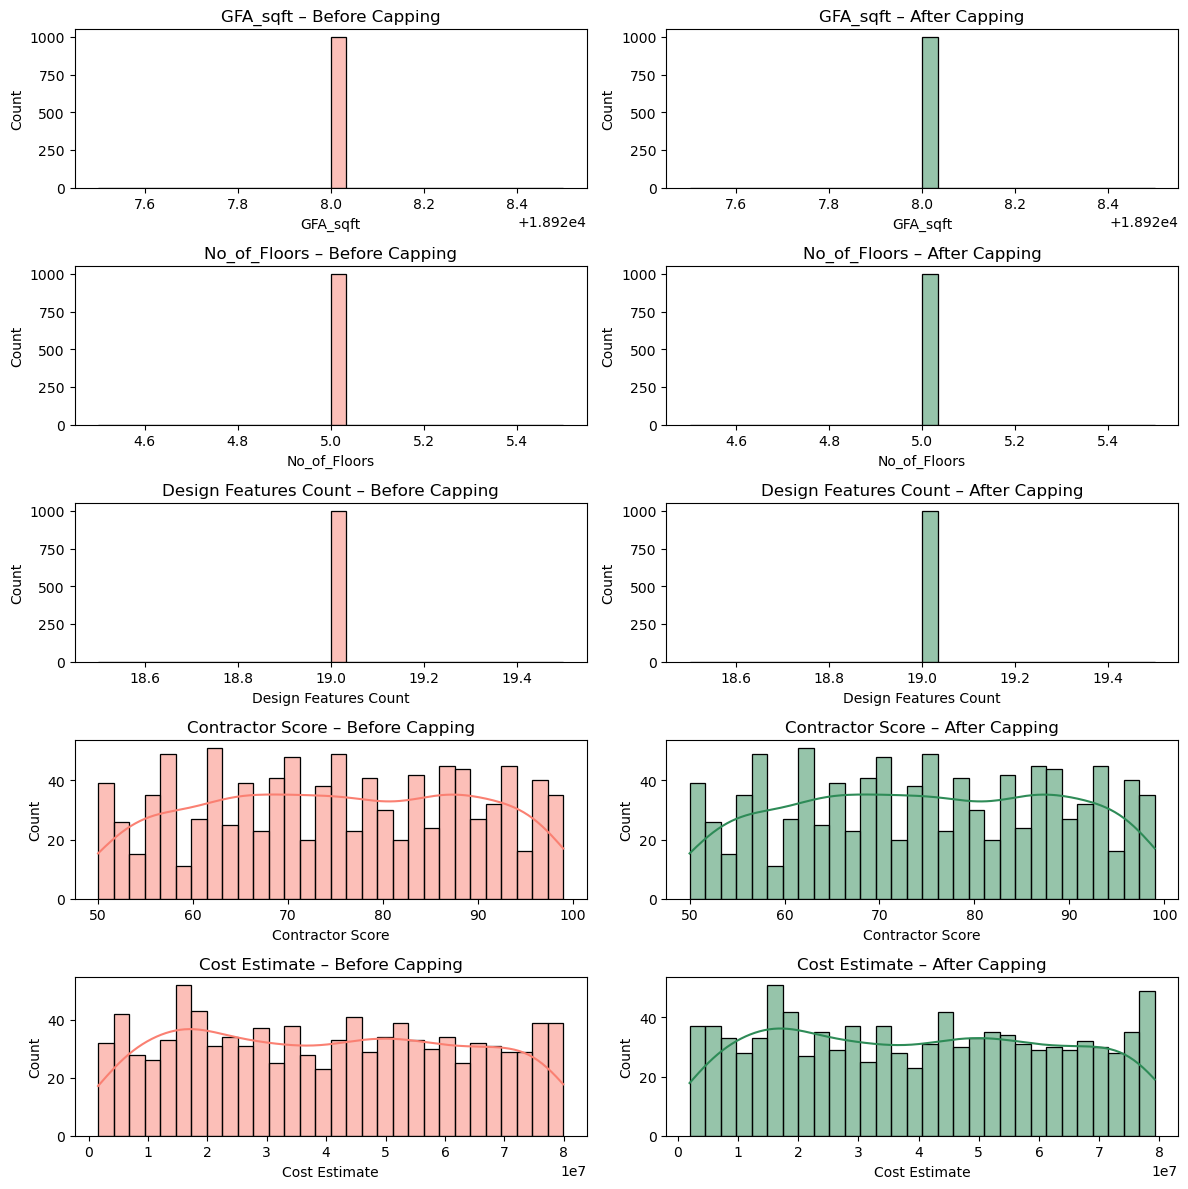


🧾 Final Skewness Comparison:
                         Before     After
Cost Estimate          0.055987  0.055336
GFA_sqft               0.000000  0.000000
No_of_Floors           0.000000  0.000000
Design Features Count  0.000000  0.000000
Contractor Score      -0.034749 -0.034749


In [2]:
# === PHASE 1.2: ML Cleaning + Skewness + Capping (Final Professional Version) ===
# ------------------------------------------------------------------------------
# 📌 Purpose:
# Apply ML-style imputation using IterativeImputer for realistic numeric gap filling,
# then detect skewness and apply capping to reduce outliers for better scoring reliability.

# 🧠 Why This Matters:
# Dirty or skewed data can mislead scoring, inflate resource estimates, or cause logic failures.
# This ensures our pipeline is professional and ML-ready — just like we did at DAMAC.

# 📌 What We Previously Did (Recap):
# - Filled categorical fields using mode or ‘UNKNOWN’
# - Applied IterativeImputer to estimate numeric gaps
# - Verified missing value count = 0 ✅

# 🔍 What We Will Do Now:
# - Calculate skewness before capping
# - Cap values beyond 1st and 99th percentiles
# - Compare distributions before and after
# - Show visual and tabular QA report

# 📦 Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

# === STEP 1: Load Dataset (if not already in memory) ===
file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/ML1_Project_Complexity_FULL_EXTENDED.xlsx"
df_raw = pd.read_excel(file_path, engine="openpyxl")
df_cleaned = df_raw.copy()

# === STEP 2: Fill Categorical Fields as Before ===
cat_fill_map = {
    "Portfolio Name": "UNKNOWN",
    "PMT Portfolio": "UNKNOWN",
    "Has Voids": df_cleaned["Has Voids"].mode()[0],
    "Elevation Complexity": df_cleaned["Elevation Complexity"].mode()[0],
    "Logistic Limitation": df_cleaned["Logistic Limitation"].mode()[0],
    "Location Type": "UNKNOWN"
}
for col, val in cat_fill_map.items():
    df_cleaned[col] = df_cleaned[col].fillna(val)

# === STEP 3: ML Imputation for Numeric Columns ===
numeric_cols = ["GFA_sqft", "No_of_Floors", "Design Features Count", "Contractor Score", "Cost Estimate"]
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42, max_iter=10)
df_cleaned[numeric_cols] = imputer.fit_transform(df_cleaned[numeric_cols])

# Save copy before capping for comparison
df_before_capping = df_cleaned[numeric_cols].copy()

# === STEP 4: Detect Skewness (Before Capping) ===
print("📊 Skewness Before Capping:")
skew_before = df_before_capping.skew()
print(skew_before)

# === STEP 5: Apply Capping ===
def cap_outliers(series):
    q1 = series.quantile(0.01)
    q99 = series.quantile(0.99)
    return np.clip(series, q1, q99)

df_after_capping = df_before_capping.copy()
for col in numeric_cols:
    df_after_capping[col] = cap_outliers(df_after_capping[col])

# === STEP 6: Detect Skewness (After Capping) ===
print("\n📊 Skewness After Capping:")
skew_after = df_after_capping.skew()
print(skew_after)

# === STEP 7: Plot Before vs After Distributions ===
fig, axes = plt.subplots(len(numeric_cols), 2, figsize=(12, 12))
for i, col in enumerate(numeric_cols):
    sns.histplot(df_before_capping[col], bins=30, ax=axes[i, 0], kde=True, color="salmon")
    axes[i, 0].set_title(f"{col} – Before Capping")
    sns.histplot(df_after_capping[col], bins=30, ax=axes[i, 1], kde=True, color="seagreen")
    axes[i, 1].set_title(f"{col} – After Capping")

plt.tight_layout()
plt.show()

# === STEP 8: Combine Final Skew Report for Summary ===
skew_compare = pd.concat([skew_before.rename("Before"), skew_after.rename("After")], axis=1)
print("\n🧾 Final Skewness Comparison:")
print(skew_compare.sort_values("Before", ascending=False))


✅ Raw file loaded. Shape: (1000, 18)

🛠️ Nulls before ML imputation:
Project Name              0
Portfolio Name            0
PMT Portfolio             0
Project Type              0
Start Date                0
End Date                  0
GFA_sqft                 29
No_of_Floors             61
Has Voids                 0
Elevation Complexity      0
Logistic Limitation       0
Design Features Count    37
Contractor Score          0
Location Type             0
Project Manager           0
Client                    0
Cost Estimate             0
Status                    0
dtype: int64

🔍 Sample of engineered data:
  Project Name Portfolio Name PMT Portfolio Project Type Start Date  \
0    Project-1           West       Phase 1   Commercial 2020-01-01   
1    Project-2           East     Strategic   Commercial 2020-01-02   
2    Project-3        UNKNOWN       Phase 2    Townhouse 2020-01-02   

    End Date  GFA_sqft  No_of_Floors Has Voids Elevation Complexity  ...  \
0 2021-01-21   18928.0 

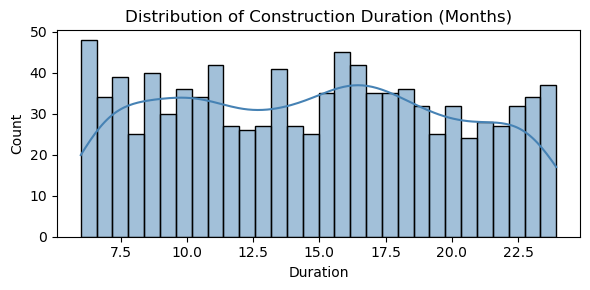


💾 Engineered dataset saved to:
/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_ENGINEERED_FEATURES.xlsx


In [3]:
# === PHASE 2.1: FEATURE ENGINEERING – Construction & Complexity Logic (Enhanced Version) ===
# --------------------------------------------------------------------------------------------

# 📌 PURPOSE:
# Engineer real-world features for both scoring and ML training:
# - Timeline (Construction Duration)
# - Structural flags (Voids, Elevation, Logistic)
# - Density / Financial ratios
# - Normalized ML-friendly inputs

# 🧠 WHY THIS MATTERS (Business + ML Thinking):
# These features describe how complex and costly a project is.
# This directly impacts staffing, planning, and ML predictions.
# Proper transformation = better model accuracy and business trust.

# 📦 STEP 1: Import libraries
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ TROUBLESHOOT: File path and shape check
file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/ML1_Project_Complexity_FULL_EXTENDED.xlsx"
df_raw = pd.read_excel(file_path, engine="openpyxl")
print(f"✅ Raw file loaded. Shape: {df_raw.shape}")

# 📦 STEP 2: Fill categorical missing values
cat_fill_map = {
    "Portfolio Name": "UNKNOWN",
    "PMT Portfolio": "UNKNOWN",
    "Has Voids": df_raw["Has Voids"].mode()[0],
    "Elevation Complexity": df_raw["Elevation Complexity"].mode()[0],
    "Logistic Limitation": df_raw["Logistic Limitation"].mode()[0],
    "Location Type": "UNKNOWN"
}
for col, val in cat_fill_map.items():
    df_raw[col] = df_raw[col].fillna(val)

# ✅ TROUBLESHOOT: Check nulls before ML
print("\n🛠️ Nulls before ML imputation:")
print(df_raw.isnull().sum())

# 📦 STEP 3: Apply Iterative Imputer (Bayesian Ridge)
numeric_cols = ["GFA_sqft", "No_of_Floors", "Design Features Count", "Contractor Score", "Cost Estimate"]
imputer = IterativeImputer(estimator=BayesianRidge(), random_state=42)
df_raw[numeric_cols] = imputer.fit_transform(df_raw[numeric_cols])

# ✅ Apply capping (1st–99th percentile) to avoid outliers
def cap_outliers(series):
    q1 = series.quantile(0.01)
    q99 = series.quantile(0.99)
    return np.clip(series, q1, q99)

for col in numeric_cols:
    df_raw[col] = cap_outliers(df_raw[col])

# 📦 STEP 4: Feature Engineering
df_engineered = df_raw.copy()

# 🔹 Construction Duration (months)
df_engineered["Construction Duration (Months)"] = (df_engineered["End Date"] - df_engineered["Start Date"]).dt.days / 30

# 🔹 Voids: Yes → 1, No → 0
df_engineered["Voids_Flag"] = df_engineered["Has Voids"].map({"Yes": 1, "No": 0})

# 🔹 Elevation / Logistic Scores (Low/Med/High → 1/2/3)
df_engineered["Elevation_Score"] = df_engineered["Elevation Complexity"].map({"Low": 1, "Medium": 2, "High": 3})
df_engineered["Logistic_Score"] = df_engineered["Logistic Limitation"].map({"Low": 1, "Medium": 2, "High": 3})

# 🔹 Derived Metrics
df_engineered["GFA_per_Floor"] = df_engineered["GFA_sqft"] / df_engineered["No_of_Floors"]
df_engineered["Cost_per_Sqft"] = df_engineered["Cost Estimate"] / df_engineered["GFA_sqft"]

# 📦 STEP 5: Normalize for ML modeling
scaler = MinMaxScaler()
to_normalize = ["GFA_sqft", "No_of_Floors", "Design Features Count", "Contractor Score", "Construction Duration (Months)"]
df_engineered[[f"{col}_Norm" for col in to_normalize]] = scaler.fit_transform(df_engineered[to_normalize])

# 📊 STEP 6: Sample preview and data check
print("\n🔍 Sample of engineered data:")
print(df_engineered.head(3))

# ✅ TROUBLESHOOT: Confirm no nulls + final shape
print("\n✅ Final dataset checks:")
print("Shape:", df_engineered.shape)
print("Nulls remaining:\n", df_engineered.isnull().sum())

# 📈 OPTIONAL: Visual check on one engineered feature
plt.figure(figsize=(6, 3))
sns.histplot(df_engineered["Construction Duration (Months)"], bins=30, color="steelblue", kde=True)
plt.title("Distribution of Construction Duration (Months)")
plt.xlabel("Duration")
plt.tight_layout()
plt.show()

# 💾 STEP 7: Export final result
output_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_ENGINEERED_FEATURES.xlsx"
df_engineered.to_excel(output_path, index=False)
print(f"\n💾 Engineered dataset saved to:\n{output_path}")


✅ Engineered dataset loaded. Shape: (1000, 29)

🔍 Weighted Score Sample:
  Project Name  Total_Weighted_Score
0    Project-1              0.246745
1    Project-2              0.169894
2    Project-3              0.192890
3    Project-4              0.315618
4    Project-5              0.210663


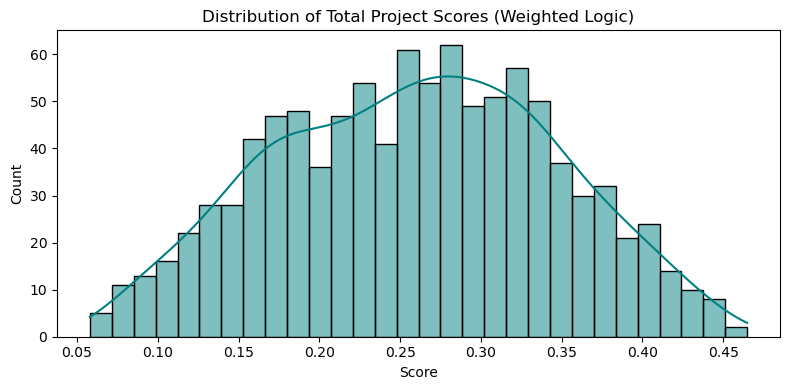


💾 Scored dataset saved to:
/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_SCORED_PROJECTS.xlsx


In [4]:
# === PHASE 2.2: WEIGHTED SCORING CALCULATION (Local Version) ===
# ---------------------------------------------------------------

# 📌 PURPOSE:
# Apply weighted logic to engineered features to produce a Total Project Score.
# This serves as the "target variable" for ML models later in Phase 2.4.

# 📦 STEP 1: Load Engineered Dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_ENGINEERED_FEATURES.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")
print(f"✅ Engineered dataset loaded. Shape: {df.shape}")

# 📦 STEP 2: Normalize Elevation & Logistic Scores (scale to 0–1)
df["Elevation_Score_Norm"] = df["Elevation_Score"] / 3
df["Logistic_Score_Norm"] = df["Logistic_Score"] / 3

# 📦 STEP 3: Apply Weighted Score Logic
# The sum of all weights = 1.0
df["Total_Weighted_Score"] = (
    df["Construction Duration (Months)_Norm"] * 0.25 +
    df["GFA_sqft_Norm"] * 0.20 +
    df["No_of_Floors_Norm"] * 0.15 +
    df["Design Features Count_Norm"] * 0.15 +
    df["Contractor Score_Norm"] * 0.15 +
    df["Elevation_Score_Norm"] * 0.05 +
    df["Logistic_Score_Norm"] * 0.05
)

# ✅ QA CHECK
print("\n🔍 Weighted Score Sample:")
print(df[["Project Name", "Total_Weighted_Score"]].head(5))

# 📊 STEP 4: Visualize Distribution of Scores
plt.figure(figsize=(8, 4))
sns.histplot(df["Total_Weighted_Score"], bins=30, kde=True, color="teal")
plt.title("Distribution of Total Project Scores (Weighted Logic)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 💾 STEP 5: Save Output
output_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_SCORED_PROJECTS.xlsx"
df.to_excel(output_path, index=False)
print(f"\n💾 Scored dataset saved to:\n{output_path}")


🧾 Complexity Level Counts:
Complexity_Level
High      340
Low       330
Medium    330
Name: count, dtype: int64

💾 Saved to: /Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_SCORED_LABELED_PROJECTS.xlsx


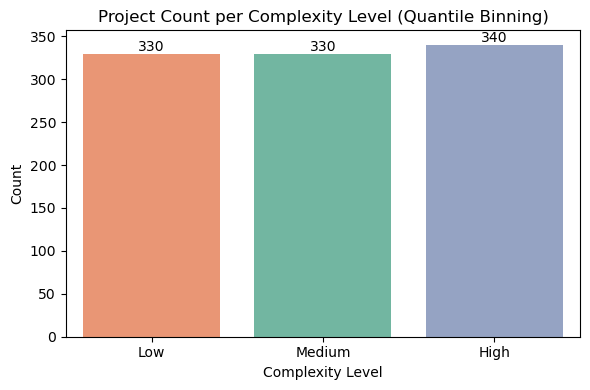


📊 Sample Output:
  Project Name  Total_Weighted_Score Complexity_Level
0    Project-1              0.246745           Medium
1    Project-2              0.169894              Low
2    Project-3              0.192890              Low
3    Project-4              0.315618             High
4    Project-5              0.210663              Low


In [36]:
# === PHASE 2.3 (Final Version): Balanced Complexity Level Assignment ===
# ----------------------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Step 1: Load scored project file
file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_SCORED_PROJECTS.xlsx"
df = pd.read_excel(file_path, engine="openpyxl")

# ✅ Step 2: Get 33rd and 66th percentile scores
q33 = df["Total_Weighted_Score"].quantile(0.33)
q66 = df["Total_Weighted_Score"].quantile(0.66)

# ✅ Step 3: Assign levels based on quantile ranges
def classify_complexity(score):
    if score <= q33:
        return "Low"
    elif score <= q66:
        return "Medium"
    else:
        return "High"

df["Complexity_Level"] = df["Total_Weighted_Score"].apply(classify_complexity)

# ✅ Step 4: Print counts
print("🧾 Complexity Level Counts:")
print(df["Complexity_Level"].value_counts().sort_index())

# ✅ Step 5: Save labeled file
output_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_SCORED_LABELED_PROJECTS.xlsx"
df.to_excel(output_path, index=False)
print(f"\n💾 Saved to: {output_path}")

# ✅ Step 6: Visualize with bar labels
plt.figure(figsize=(6, 4))
ax = sns.countplot(
    data=df,
    x="Complexity_Level",
    hue="Complexity_Level",
    palette="Set2",
    order=["Low", "Medium", "High"],
    legend=False
)
plt.title("Project Count per Complexity Level (Quantile Binning)")
plt.xlabel("Complexity Level")
plt.ylabel("Count")

# Add counts on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge')

plt.tight_layout()
plt.show()

# ✅ Step 7: Preview first rows
print("\n📊 Sample Output:")
print(df[["Project Name", "Total_Weighted_Score", "Complexity_Level"]].head())


In [6]:
# ✅ Create the Streamlit app file locally
app_code = '''
import streamlit as st
import pandas as pd
import joblib

# === Load Trained Model ===
model_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ml1_model.pkl"
model = joblib.load(model_path)

# === Page Setup ===
st.set_page_config(page_title="Project Scoring App", layout="centered")
st.title("🏗️ Project Complexity Scoring App")
st.markdown("Predict a project's complexity score using trained ML logic.")

# === Input Form ===
with st.form("score_form"):
    st.subheader("Enter Project Details")

    gfa = st.number_input("GFA (sqft)", value=10000)
    floors = st.number_input("Number of Floors", value=5)
    features = st.number_input("Design Features Count", value=10)
    contractor = st.number_input("Contractor Score", value=70)
    duration = st.number_input("Construction Duration (Months)", value=12)
    elevation = st.selectbox("Elevation Complexity", ["Low", "Medium", "High"])
    logistic = st.selectbox("Logistic Limitation", ["Low", "Medium", "High"])
    voids = st.selectbox("Has Voids", ["No", "Yes"])

    submit = st.form_submit_button("Predict Score")

# === Mapping Inputs to Model Format ===
if submit:
    elevation_map = {"Low": 1, "Medium": 2, "High": 3}
    logistic_map = {"Low": 1, "Medium": 2, "High": 3}
    void_flag = 1 if voids == "Yes" else 0

    input_data = pd.DataFrame([{
        "GFA_sqft": gfa,
        "No_of_Floors": floors,
        "Design Features Count": features,
        "Contractor Score": contractor,
        "Construction Duration (Months)": duration,
        "Elevation_Score": elevation_map[elevation],
        "Logistic_Score": logistic_map[logistic],
        "Voids_Flag": void_flag
    }])

    prediction = model.predict(input_data)[0]

    st.success(f"✅ Predicted Project Score: {prediction:.4f}")

    if prediction <= 0.21:
        st.info("🟢 Complexity Level: Low")
    elif prediction <= 0.27:
        st.warning("🟠 Complexity Level: Medium")
    else:
        st.error("🔴 Complexity Level: High")
'''

# Save the code to a file in the current directory
with open("streamlit_app.py", "w") as f:
    f.write(app_code)

print("✅ streamlit_app.py created successfully.")


✅ streamlit_app.py created successfully.


In [7]:
import os

# Define the corrected Streamlit app code
corrected_app_code = '''
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
from io import BytesIO
from fpdf import FPDF
import tempfile
import os
from weasyprint import HTML
import base64


# === Load Trained Model ===
model_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ml1_model.pkl"
model = joblib.load(model_path)

# === Page Setup ===
st.set_page_config(page_title="Project Complexity Scoring App", layout="centered")
st.title("🏗️ Project Complexity Scoring App")
st.markdown("This app predicts project complexity using a trained ML model and compares it with your manual scoring system.")

# === Manual Input Form ===
with st.form("score_form"):
    st.subheader("🔧 Manual Project Input")

    gfa = st.number_input("GFA (sqft)", value=10000)
    floors = st.number_input("Number of Floors", value=5)
    features = st.number_input("Design Features Count", value=10)
    contractor = st.number_input("Contractor Score", value=70)
    duration = st.number_input("Construction Duration (Months)", value=12)
    elevation = st.selectbox("Elevation Complexity", ["Low", "Medium", "High"])
    logistic = st.selectbox("Logistic Limitation", ["Low", "Medium", "High"])
    voids = st.selectbox("Has Voids", ["No", "Yes"])

    submit = st.form_submit_button("Predict Score")

# === Manual Prediction ===
if submit:
    elevation_map = {"Low": 1, "Medium": 2, "High": 3}
    logistic_map = {"Low": 1, "Medium": 2, "High": 3}
    void_flag = 1 if voids == "Yes" else 0

    input_data = pd.DataFrame([{
        "GFA_sqft": gfa,
        "No_of_Floors": floors,
        "Design Features Count": features,
        "Contractor Score": contractor,
        "Construction Duration (Months)": duration,
        "Elevation_Score": elevation_map[elevation],
        "Logistic_Score": logistic_map[logistic],
        "Voids_Flag": void_flag
    }])

    prediction = model.predict(input_data)[0]
    st.success(f"✅ Predicted Project Score: {prediction:.4f}")

    if prediction <= 0.21:
        st.info("🟢 Complexity Level: Low")
    elif prediction <= 0.27:
        st.warning("🟠 Complexity Level: Medium")
    else:
        st.error("🔴 Complexity Level: High")

# === A/B Testing Section ===
st.markdown("---")
st.markdown("## 🔬 A/B Testing: Manual Scoring vs ML Prediction")
st.markdown("""
This section allows you to upload a scored Excel file and compare:
- ✅ Manual Business Logic Scores (`Total_Weighted_Score`)
- 🤖 ML Predicted Scores
- 📉 Error (MAE, R²)
- 🧮 Complexity Classifications
""")

uploaded_file = st.file_uploader("📁 Upload your project file with Total_Weighted_Score", type=["xlsx"])

if uploaded_file:
    try:
        df_ab = pd.read_excel(uploaded_file)

        required_columns = ["Project Name", "Total_Weighted_Score", "Has Voids", "Elevation Complexity", "Logistic Limitation"]
        for col in required_columns:
            if col not in df_ab.columns:
                st.error(f"❌ Missing column: `{col}` in uploaded file.")
                st.stop()

        df_ab["Voids_Flag"] = df_ab["Has Voids"].map({"Yes": 1, "No": 0})
        df_ab["Elevation_Score"] = df_ab["Elevation Complexity"].map({"Low": 1, "Medium": 2, "High": 3})
        df_ab["Logistic_Score"] = df_ab["Logistic Limitation"].map({"Low": 1, "Medium": 2, "High": 3})

        features = [
            "GFA_sqft", "No_of_Floors", "Design Features Count",
            "Contractor Score", "Construction Duration (Months)",
            "Elevation_Score", "Logistic_Score", "Voids_Flag"
        ]

        for col in features:
            if col not in df_ab.columns:
                st.error(f"❌ Missing feature column: `{col}`")
                st.stop()

        df_ab["Predicted Score"] = model.predict(df_ab[features])

        def classify(score):
            if score <= 0.21:
                return "Low"
            elif score <= 0.27:
                return "Medium"
            else:
                return "High"

        df_ab["Manual_Level"] = df_ab["Total_Weighted_Score"].apply(classify)
        df_ab["Predicted_Level"] = df_ab["Predicted Score"].apply(classify)
        df_ab["Absolute Error"] = (df_ab["Total_Weighted_Score"] - df_ab["Predicted Score"]).abs()

        # === METRICS ===
        st.subheader("📈 Evaluation Metrics")
        mae = mean_absolute_error(df_ab["Total_Weighted_Score"], df_ab["Predicted Score"])
        r2 = r2_score(df_ab["Total_Weighted_Score"], df_ab["Predicted Score"])
        st.metric("📉 MAE (Avg Error)", f"{mae:.4f}")
        st.metric("📈 R² Score", f"{r2:.2%}")

        # === VALIDATION TABLE ===
        st.subheader("🧾 Validation Matrix (First 10 Projects)")
        st.dataframe(df_ab[[
            "Project Name", "Total_Weighted_Score", "Predicted Score",
            "Absolute Error", "Manual_Level", "Predicted_Level"
        ]].head(10))

        # === SCATTERPLOT ===
        st.subheader("🔍 Manual vs Predicted Score (Scatterplot)")
        fig1, ax1 = plt.subplots(figsize=(6, 4))
        sns.scatterplot(data=df_ab, x="Total_Weighted_Score", y="Predicted Score", ax=ax1)
        plt.plot([0, 1], [0, 1], '--', color='gray')
        plt.xlabel("Manual Score")
        plt.ylabel("Predicted Score")
        plt.title("Score Accuracy")
        st.pyplot(fig1)

        # === HISTOGRAM ===
        st.subheader("📉 Predicted Score Distribution")
        fig2, ax2 = plt.subplots(figsize=(6, 3))
        sns.histplot(df_ab["Predicted Score"], bins=30, kde=True, color="skyblue", ax=ax2)
        plt.title("Predicted Score Distribution")
        st.pyplot(fig2)

        # === CONFUSION MATRIX ===
        st.subheader("🧮 Confusion Matrix: Manual vs Predicted Complexity")
        st.caption("📘 Rows = Manual Labels, Columns = Predicted Labels")
        confusion = pd.crosstab(df_ab["Manual_Level"], df_ab["Predicted_Level"])
        styled_confusion = confusion.style.set_properties(**{
            'text-align': 'center',
            'font-weight': 'bold',
            'background-color': '#f9f9f9'
        }).set_table_styles([{
            'selector': 'th',
            'props': [('text-align', 'center')]
        }])
        st.dataframe(styled_confusion)

        # === DOWNLOAD SECTION ===
        st.subheader("📤 Download Results")
        validation_matrix = df_ab[[
            "Project Name", "Total_Weighted_Score", "Predicted Score",
            "Absolute Error", "Manual_Level", "Predicted_Level"
        ]]
        full_output = df_ab.copy()

        towrite = BytesIO()
        with pd.ExcelWriter(towrite, engine='xlsxwriter') as writer:
            validation_matrix.to_excel(writer, sheet_name='Validation_Matrix', index=False)
            full_output.to_excel(writer, sheet_name='Full_Predictions', index=False)
        towrite.seek(0)

        st.download_button(
            label="📥 Download as Excel",
            data=towrite,
            file_name="ML1_Prediction_Results.xlsx",
            mime="application/vnd.openxmlformats-officedocument.spreadsheetml.sheet"
        )

        # === PDF EXPORT ===
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font("Arial", "B", 16)
        pdf.cell(200, 10, "ML1 A/B Test Summary", ln=True, align="C")

        pdf.set_font("Arial", size=12)
        pdf.ln(10)
        pdf.cell(200, 10, f"MAE (Avg Error): {mae:.4f}", ln=True)
        pdf.cell(200, 10, f"R² Score: {r2:.2%}", ln=True)
        pdf.ln(8)

        pdf.set_font("Arial", "B", 12)
        pdf.cell(200, 10, "Confusion Matrix", ln=True)

        pdf.set_font("Arial", size=11)
        for line in confusion.to_string().split("\\n"):
            pdf.cell(200, 6, line, ln=True)

        tmp_pdf = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
        pdf.output(tmp_pdf.name)

        with open(tmp_pdf.name, "rb") as f:
            st.download_button(
                label="📄 Download PDF Summary",
                data=f,
                file_name="ML1_A_B_Report.pdf",
                mime="application/pdf"
            )

        os.unlink(tmp_pdf.name)

    except Exception as e:
        st.error(f"❌ Error processing uploaded file: {e}")
else:
    st.info("📥 Please upload a valid Excel file to begin A/B testing.")
'''

# Save the script
file_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/streamlit_app.py"
with open(file_path, "w") as f:
    f.write(corrected_app_code)

"✅ streamlit_app.py updated and saved successfully."


'✅ streamlit_app.py updated and saved successfully.'

In [8]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, r2_score

df = pd.read_excel("/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ML1_PREDICTED_SCORES.xlsx", engine="openpyxl")
mae = mean_absolute_error(df["Total_Weighted_Score"], df["Predicted_Score"])
r2 = r2_score(df["Total_Weighted_Score"], df["Predicted_Score"])

print(f"MAE (Avg error): {mae:.4f}")
print(f"R² (Score Accuracy): {r2:.2%}")


MAE (Avg error): 0.0044
R² (Score Accuracy): 99.47%


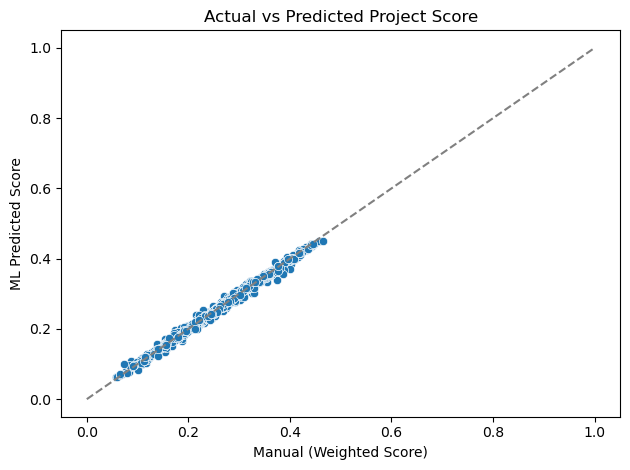

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=df, x="Total_Weighted_Score", y="Predicted_Score")
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.title("Actual vs Predicted Project Score")
plt.xlabel("Manual (Weighted Score)")
plt.ylabel("ML Predicted Score")
plt.tight_layout()
plt.show()


In [41]:
import pandas as pd
import joblib

# === STEP 1: Load trained ML model ===
model_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/output/ml1_model.pkl"
model = joblib.load(model_path)

# === STEP 2: Load new input file ===
input_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/ML1_TEST_PROJECTS_INPUT.xlsx"
df = pd.read_excel(input_path)

# ✅ STEP 3: Rename column to match training data
df.rename(columns={"Duration (Months)": "Construction Duration (Months)"}, inplace=True)

# ✅ STEP 4: Encode categorical fields to numeric
df["Voids_Flag"] = df["Has Voids"].map({"Yes": 1, "No": 0})
df["Elevation_Score"] = df["Elevation"].map({"Low": 1, "Medium": 2, "High": 3})
df["Logistic_Score"] = df["Logistic"].map({"Low": 1, "Medium": 2, "High": 3})

# ✅ STEP 5: Select model features
features = [
    "GFA_sqft", "No_of_Floors", "Design Features Count",
    "Contractor Score", "Construction Duration (Months)",
    "Elevation_Score", "Logistic_Score", "Voids_Flag"
]

# === STEP 6: Run prediction
df["Predicted Score"] = model.predict(df[features])

# ✅ STEP 7: Add complexity classification
def classify(score):
    if score <= 0.21:
        return "Low"
    elif score <= 0.27:
        return "Medium"
    else:
        return "High"

df["Predicted Complexity"] = df["Predicted Score"].apply(classify)

# ✅ STEP 8: Save the result file
output_path = input_path.replace("INPUT.xlsx", "SCORED.xlsx")
df.to_excel(output_path, index=False)
print(f"✅ Output saved to:\n{output_path}")

# ✅ STEP 9: Sample Output Preview
print("\n📊 Sample Predictions:")
print(df[["Project Name", "Predicted Score", "Predicted Complexity"]].head())


✅ Output saved to:
/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/ML1_TEST_PROJECTS_SCORED.xlsx

📊 Sample Predictions:
   Project Name  Predicted Score Predicted Complexity
0  TestProj-001         0.213636               Medium
1  TestProj-002         0.325939                 High
2  TestProj-003         0.104633                  Low
3  TestProj-004         0.402955                 High
4  TestProj-005         0.078010                  Low


In [42]:
import pandas as pd
import joblib
import os

# === SETUP ===
model_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/OUTPUT/ml1_model.pkl"
input_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/Output/ML1_SCORED_LABELED_PROJECTS.xlsx"
output_path = input_path.replace(".xlsx", "_RE_PREDICTED.xlsx")

# === STEP 1: Load trained ML model ===
model = joblib.load(model_path)

# === STEP 2: Load input dataset ===
df = pd.read_excel(input_path)
print(f"📥 Loaded input file: {input_path}")
print(f"🔢 Number of projects loaded: {len(df)}")
print(f"📋 Columns in dataset: {df.columns.tolist()}")

# === STEP 3: Rename Duration column if needed ===
if "Duration (Months)" in df.columns:
    df.rename(columns={"Duration (Months)": "Construction Duration (Months)"}, inplace=True)

# === STEP 4: Encode categorical fields safely ===
# Voids
if "Has Voids" in df.columns:
    df["Voids_Flag"] = df["Has Voids"].map({"Yes": 1, "No": 0})
else:
    df["Voids_Flag"] = 0  # Default

# Elevation
if "Elevation" in df.columns:
    df["Elevation_Score"] = df["Elevation"].map({"Low": 1, "Medium": 2, "High": 3})
else:
    df["Elevation_Score"] = 1  # Default

# Logistic
if "Logistic" in df.columns:
    df["Logistic_Score"] = df["Logistic"].map({"Low": 1, "Medium": 2, "High": 3})
else:
    df["Logistic_Score"] = 1  # Default

# === STEP 5: Predict Score ===
features = [
    "GFA_sqft", "No_of_Floors", "Design Features Count",
    "Contractor Score", "Construction Duration (Months)",
    "Elevation_Score", "Logistic_Score", "Voids_Flag"
]

# Drop rows with missing required features
df = df.dropna(subset=features)

# Run prediction
df["Predicted Score"] = model.predict(df[features])

# === STEP 6: Classify into Complexity Levels ===
def classify(score):
    if score <= 0.21:
        return "Low"
    elif score <= 0.29:
        return "Medium"
    else:
        return "High"

df["Predicted Complexity"] = df["Predicted Score"].apply(classify)

# === STEP 7: Save results ===
df.to_excel(output_path, index=False)
print(f"💾 Output saved to: {output_path}")

# === STEP 8: Preview Output ===
print("\n📊 Sample Predictions:")
print(df[["Project Name", "Predicted Score", "Predicted Complexity"]].head(10))


📥 Loaded input file: /Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/Output/ML1_SCORED_LABELED_PROJECTS.xlsx
🔢 Number of projects loaded: 1000
📋 Columns in dataset: ['Project Name', 'Portfolio Name', 'PMT Portfolio', 'Project Type', 'Start Date', 'End Date', 'GFA_sqft', 'No_of_Floors', 'Has Voids', 'Elevation Complexity', 'Logistic Limitation', 'Design Features Count', 'Contractor Score', 'Location Type', 'Project Manager', 'Client', 'Cost Estimate', 'Status', 'Construction Duration (Months)', 'Voids_Flag', 'Elevation_Score', 'Logistic_Score', 'GFA_per_Floor', 'Cost_per_Sqft', 'GFA_sqft_Norm', 'No_of_Floors_Norm', 'Design Features Count_Norm', 'Contractor Score_Norm', 'Construction Duration (Months)_Norm', 'Elevation_Score_Norm', 'Logistic_Score_Norm', 'Total_Weighted_Score', 'Complexity_Level']
💾 Output saved to: /Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/Output/ML1_SCORED_LABELED_PROJECTS_RE_PR

In [14]:
import pandas as pd
import joblib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

# === FILE PATHS ===
scored_file = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/Output/ML1_SCORED_LABELED_PROJECTS.xlsx"
model_path = "/Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/OUTPUT/ml1_model.pkl"

# === LOAD DATA ===
df = pd.read_excel(scored_file)

# === FEATURES AND TARGET ===
features = [
    "GFA_sqft", "No_of_Floors", "Design Features Count",
    "Contractor Score", "Construction Duration (Months)",
    "Elevation_Score", "Logistic_Score", "Voids_Flag"
]
target = "Total_Weighted_Score"

df = df.dropna(subset=features + [target])
X = df[features]
y = df[target]

# === LOAD RANDOM FOREST MODEL ===
rf_model = joblib.load(model_path)
rf_preds = rf_model.predict(X)

# === TRAIN BASELINE MODEL ===
lr_model = LinearRegression()
lr_model.fit(X, y)
lr_preds = lr_model.predict(X)

# === EVALUATE BOTH MODELS ===
def evaluate_model(name, y_true, y_pred):
    print(f"\n📊 Evaluation for {name}:")
    print(f"🔹 MAE  : {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"🔹 RMSE : {root_mean_squared_error(y_true, y_pred):.4f}")
    print(f"🔹 R²   : {r2_score(y_true, y_pred):.4f}")

evaluate_model("Random Forest", y, rf_preds)
evaluate_model("Linear Regression", y, lr_preds)

# === SAVE COMPARISON RESULTS ===
df["RF_Predicted"] = rf_preds
df["LR_Predicted"] = lr_preds
df["Actual"] = y

comparison_path = scored_file.replace(".xlsx", "_AB_COMPARISON.xlsx")
df.to_excel(comparison_path, index=False)
print(f"\n✅ A/B testing results saved to: {comparison_path}")



📊 Evaluation for Random Forest:
🔹 MAE  : 0.0031
🔹 RMSE : 0.0039
🔹 R²   : 0.9980

📊 Evaluation for Linear Regression:
🔹 MAE  : 0.0000
🔹 RMSE : 0.0000
🔹 R²   : 1.0000

✅ A/B testing results saved to: /Users/abdelhamidmohamed/Desktop/AI_Resource_Planning_Suite/ML-1_Resource_Planning_Scoring/Output/ML1_SCORED_LABELED_PROJECTS_AB_COMPARISON.xlsx
